<h1>Understanding QSP-Generated Quantum Circuit Scaling</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook examines how the circuits generated by pyQSP scale.


In [1]:
### 
### Publicly Available Libraries:
###
import sys
import os
import time,datetime
import cirq
import numpy             as np
import matplotlib.pyplot as plt
import pandas as pd


###
### Imports to support the pyQSP Gate-Based simulation
###
from pyLIQTR.QSP import gen_qsp     as qspFuncs
from pyLIQTR.QSP import QSP         as pQSP
from pyLIQTR.QSP.Hamiltonian import Hamiltonian as pyH

from pyLIQTR.QSP.qsp_helpers import qsp_decompose_once, print_to_openqasm, count_qubits

import pyLIQTR.sim_methods.quantum_ops as qops        
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform

<h2> Generate Hamiltonians to solve the Heisenberg problem of varying sizes </h2>

Note: Angle generation can take considerable time. Since we aren't performing the actual circuit simulation, but only looking for a resource assessment, we use the "random" mode of compute_hamiltonian_angles to calculate the correct number of angles that would need to be used for this Hamiltonian, timestep, and precision (however, the values of the angles themselves are random)

In [2]:
###
### User Input: Heisenberg Problem Specification
###

#Physical problem specification, this is equivalent to the XXZ Hamiltonian specified in Tutorials 1 & 2, though we
#vary the number of spins to show the effect of scaling.

#We note that increasing N will increase circuit size (both in terms of width and depth), since additional
#qubits are required to model the problem (width)

#Setting J/h from zero to nonzero may also increase the circuit depth, since additional terms in the Hamiltonian 
#are introduced
Ns     =  [4, 8, 16, 24, 32 , 40, 48, 64] #, 128]           # Size of the problem
                                               
J_z  =    1.0;
J_x  =    1.1*J_z;     J_y  =   J_x;               
h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

# Algorithm specification
#  Increasing the precision or increasing simulation time will increase circuit depth by introducing
#  additional phases / iterates.

timestep_of_interest = 0.05
required_precision   = 1e-4



ham_strings = []
qsp_hams    = []
angles      = []
for N_ in Ns:
    tuples,types,coeffs = qops.params_heisenberg_1d(N_,
                                                J_x=J_x,J_y=J_y,J_z=J_z,
                                                h_x=h_x,h_y=h_y,h_z=h_z,
                                                periodic=False)
    curr_hs = qops.ps_text_full_set(tuples,types,N_,Coeffs=coeffs)
    curr_qsp_H = pyH(curr_hs)
    
    qsp_hams.append(curr_qsp_H)
    ham_strings.append(curr_hs)
    # Here we use the random mode for angle generation, which generates a set of random angles
    print("Start computing angles for {}:{}".format(N_,datetime.datetime.now()))
    angles.append(qspFuncs.compute_hamiltonian_angles(curr_qsp_H, timestep_of_interest, required_precision, mode="random")[0])
    print("\tFinish computing angles for {}:{}".format(N_,datetime.datetime.now()))

    

Start computing angles for 4:2023-03-10 15:49:31.253319
	Finish computing angles for 4:2023-03-10 15:49:31.255329
Start computing angles for 8:2023-03-10 15:49:31.255329
	Finish computing angles for 8:2023-03-10 15:49:31.256326
Start computing angles for 16:2023-03-10 15:49:31.256326
	Finish computing angles for 16:2023-03-10 15:49:31.257328
Start computing angles for 24:2023-03-10 15:49:31.258327
	Finish computing angles for 24:2023-03-10 15:49:31.259330
Start computing angles for 32:2023-03-10 15:49:31.260320
	Finish computing angles for 32:2023-03-10 15:49:31.261329
Start computing angles for 40:2023-03-10 15:49:31.262326
	Finish computing angles for 40:2023-03-10 15:49:31.263326
Start computing angles for 48:2023-03-10 15:49:31.264326
	Finish computing angles for 48:2023-03-10 15:49:31.265326
Start computing angles for 64:2023-03-10 15:49:31.266326
	Finish computing angles for 64:2023-03-10 15:49:31.268326


<h2> Generate each of the circuits </h2>

In [3]:
###
### A function to generate the circuit scaling statistics. Left in the notebook
### to enable future customizability.
###

def generate_circuit_stats(ham, angs, csv_out='scaling_data.csv', save_circuit=False):

    t_start_time = time.time()

    # Generate circuit:
    qsp_generator   = pQSP.QSP(phis=angs, hamiltonian=ham, target_size=ham.problem_size)
    curr_circ       = qsp_generator.circuit()
    t_initial_generation_time = time.time()

    # Decompose circuit:
    decomposed_circuit       = cirq.align_left(qsp_decompose_once(qsp_decompose_once(curr_circ)))
    t_decomp_to_toffoli_time = time.time()

    cliffT_decomp_circuit   = cirq.align_left(clifford_plus_t_direct_transform(decomposed_circuit))
    t_decomp_to_cliffT_time = time.time()

    if save_circuit:
        # Save circuit to file in OpenQASM 2.0 format:
        with open(f'open_qasm_for_problem_size_{H.problem_size}_toffoli.qasm', 'w') as f:
            print_to_openqasm(f, decomposed_circuit)
        t_write_toffoli_time = time.time()
        
        with open(f'open_qasm_for_problem_size_{H.problem_size}_cliffT.qasm', 'w') as f:
            print_to_openqasm(f, cliffT_decomp_circuit)
        t_write_cliffT_time = time.time()


    # Lets write all this stuff out:
    if os.path.exists(csv_out):
        yes_header = False
    else:
        yes_header = True
    out_file = open(csv_out, 'a')
    if yes_header:
        out_file.write('Prob_Size,Circ_Gen_Time,Toff_Decomp_Time,CliffT_Decomp_Time,Write_Out_Toff_Time,Write_Out_CliffT_Time,Ttl_Qubits,Anc_Qubits,Ctl_Qubits,Circ_Depth_Toff,Circ_Depth_cliffT\n')

    # Calculate the times
    t_gen    = (t_initial_generation_time - t_start_time)
    t_toff   = (t_decomp_to_toffoli_time  - t_initial_generation_time)
    t_clifft = (t_decomp_to_cliffT_time   - t_decomp_to_toffoli_time)
    if save_circuit:
        t_write_out_toff   = (t_write_toffoli_time - t_decomp_to_cliffT_time)
        t_write_out_cliffT = (t_write_cliffT_time  - t_write_toffoli_time)
    else:
        t_write_out_toff   = -1
        t_write_out_cliffT = -1

    print_string = f'{ham.problem_size},{t_gen},{t_toff},{t_clifft},{t_write_out_toff},{t_write_out_cliffT}'

    ttl_qubits, ctl_qubits, anc_qubits = count_qubits(curr_circ)

    print_string += f',{ttl_qubits},{anc_qubits},{ctl_qubits}'


    depth_toff   = len(cirq.align_left(decomposed_circuit))
    depth_cliffT = len(cirq.align_left(cliffT_decomp_circuit))

    print_string += f',{depth_toff},{depth_cliffT}\n'

    out_file.write(print_string)

In [4]:
# Run the function above to generate circuit statistics for the specified circuits
#
if os.path.exists('scaling_data.csv'):
    os.remove('scaling_data.csv')
for H, angs in zip(qsp_hams, angles):
    print("Start generating @ {}".format(datetime.datetime.now()))
    generate_circuit_stats(H, angs)
    print("\tFinish generating @ {}".format(datetime.datetime.now()))

data = pd.read_csv('scaling_data.csv')

Start generating @ 2023-03-10 15:49:31.334723
	Finish generating @ 2023-03-10 15:49:35.342329
Start generating @ 2023-03-10 15:49:35.342329
	Finish generating @ 2023-03-10 15:49:44.901089
Start generating @ 2023-03-10 15:49:44.901089
	Finish generating @ 2023-03-10 15:50:11.394718
Start generating @ 2023-03-10 15:50:11.395179
	Finish generating @ 2023-03-10 15:51:34.854148
Start generating @ 2023-03-10 15:51:34.854148
	Finish generating @ 2023-03-10 15:52:40.942423
Start generating @ 2023-03-10 15:52:40.943251
	Finish generating @ 2023-03-10 15:56:33.785473
Start generating @ 2023-03-10 15:56:33.786393
	Finish generating @ 2023-03-10 16:02:14.567160
Start generating @ 2023-03-10 16:02:14.567160
	Finish generating @ 2023-03-10 16:07:11.906108


In [5]:
# Read data that was previously calculated

data = pd.read_csv('./scaling_data.csv')

<h2> Analyze the generated circuit data </h2>

In [6]:
data

,Prob_Size,Circ_Gen_Time,Toff_Decomp_Time,CliffT_Decomp_Time,Write_Out_Toff_Time,Write_Out_CliffT_Time,Ttl_Qubits,Anc_Qubits,Ctl_Qubits,Circ_Depth_Toff,Circ_Depth_cliffT
0,4,0.002267,0.164487,2.734365,-1,-1,13,4,4,1115,47220
1,8,0.002020,0.483836,6.080731,-1,-1,19,5,5,3245,130284
2,16,0.003181,1.473509,16.045816,-1,-1,29,6,6,10173,404736
3,24,0.002528,2.975369,59.234725,-1,-1,39,7,7,19961,950529
4,32,0.003975,4.326030,37.470136,-1,-1,47,7,7,27805,1111183
5,40,0.004999,8.698386,156.139051,-1,-1,57,8,8,51597,2737955
6,48,0.008074,14.438916,240.110059,-1,-1,65,8,8,63621,3042714
7,64,0.006999,24.939307,165.191166,-1,-1,81,8,8,91621,3661932


Text(0, 0.5, 'Time [msec]')

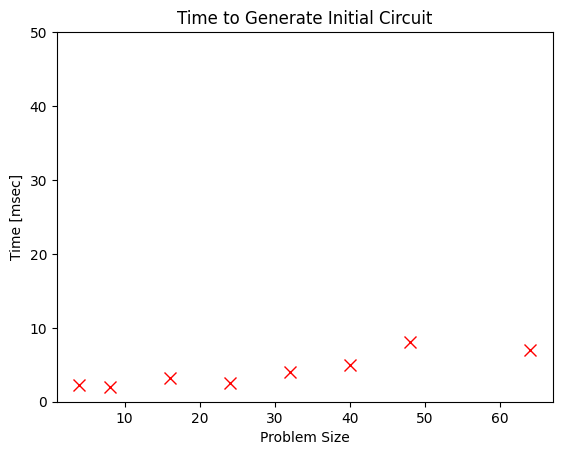

In [7]:
###
### Timing:
###


# plt.figure(figsize=(10/2,7.5/2), dpi=300)

plt.plot(data['Prob_Size'], data['Circ_Gen_Time']*1000, 'rx', markersize=8)
plt.ylim([0, 50])
plt.title('Time to Generate Initial Circuit')
plt.xlabel('Problem Size')
plt.ylabel('Time [msec]')

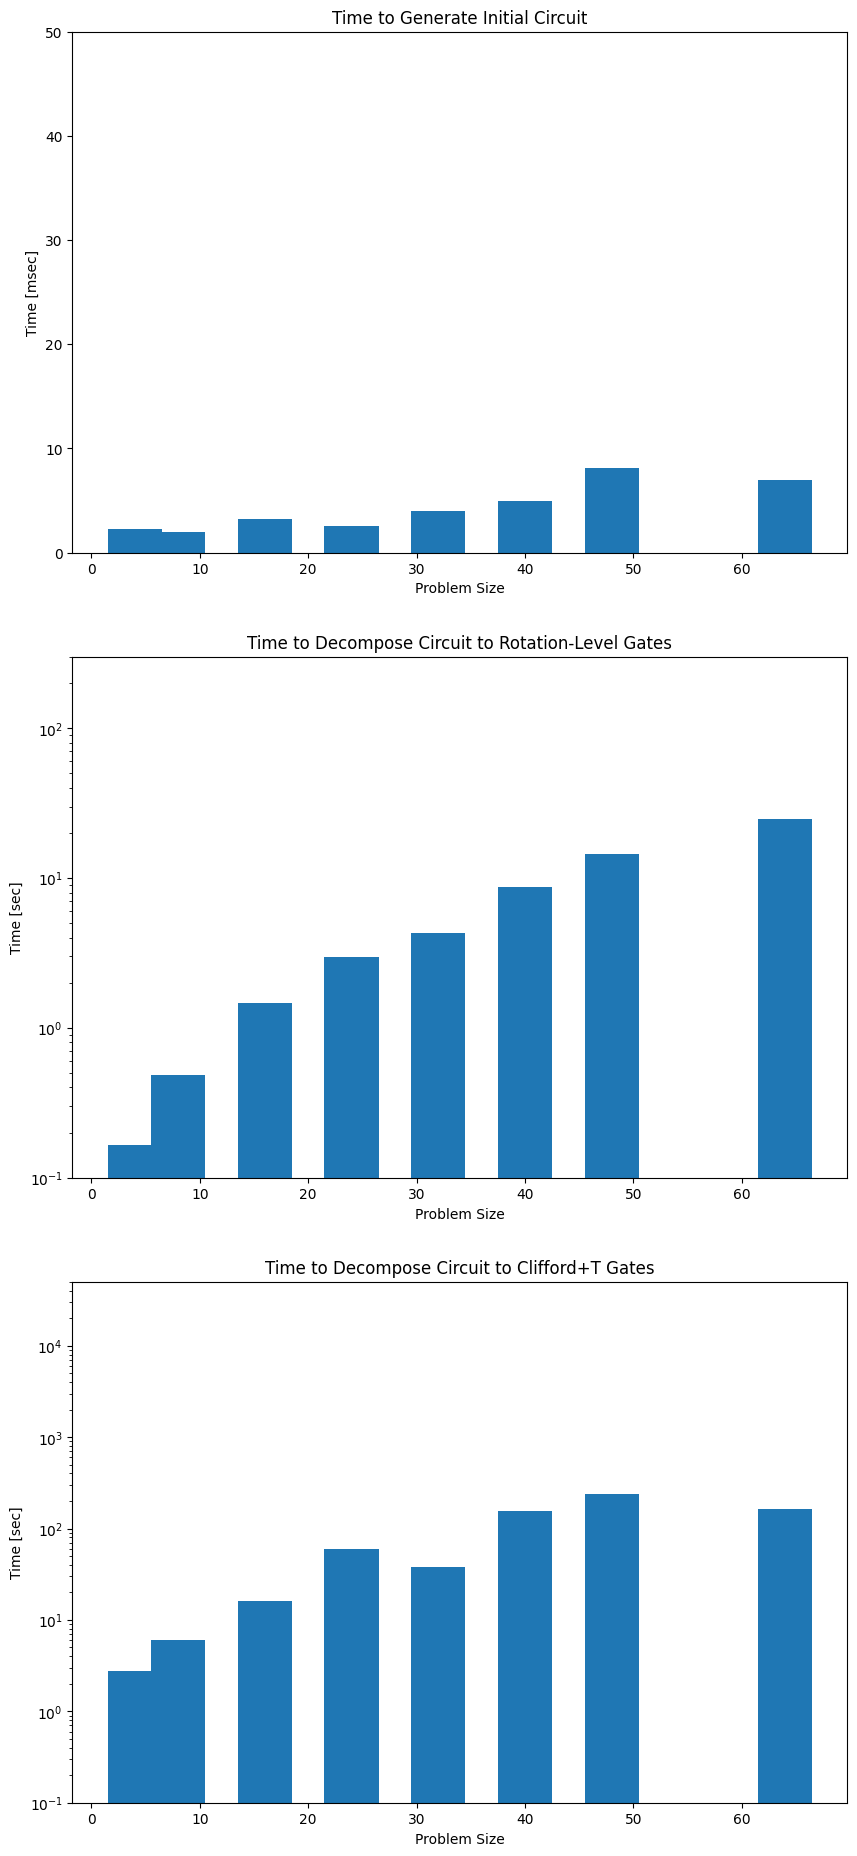

In [8]:
###
### Timing:
###

fig_time, ax_time = plt.subplots(3)
fig_time.set_figheight(23)
fig_time.set_figwidth(10)

ax_time[0].bar(data['Prob_Size'], data['Circ_Gen_Time']*1000, width=5)
ax_time[0].set_ylim([0, 50])
ax_time[0].set_title('Time to Generate Initial Circuit')
ax_time[0].set_xlabel('Problem Size')
ax_time[0].set_ylabel('Time [msec]')

ax_time[1].bar(data['Prob_Size'], data['Toff_Decomp_Time'], width=5)
ax_time[1].set_ylim([0.1, 300])
ax_time[1].set_title('Time to Decompose Circuit to Rotation-Level Gates')
ax_time[1].set_xlabel('Problem Size')
ax_time[1].set_ylabel('Time [sec]')
ax_time[1].set_yscale('log')

ax_time[2].bar(data['Prob_Size'], data['CliffT_Decomp_Time'], width=5)
ax_time[2].set_ylim([0.1, 50000])
ax_time[2].set_title('Time to Decompose Circuit to Clifford+T Gates')
ax_time[2].set_xlabel('Problem Size')
ax_time[2].set_ylabel('Time [sec]')
ax_time[2].set_yscale('log')


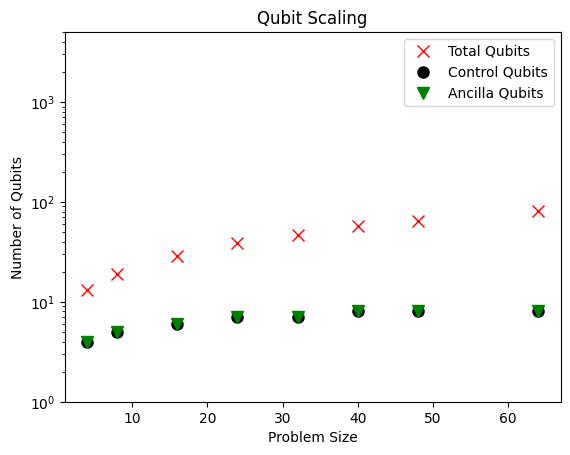

In [9]:
###
### Number of Qubits:
###
# plt.figure(figsize=(10/2,7.5/2), dpi=200)
plt.plot(data['Prob_Size'], data['Ttl_Qubits'], 'rx', markersize=8)
plt.plot(data['Prob_Size'], data['Ctl_Qubits'], 'ko', markersize=8)
plt.plot(data['Prob_Size'], data['Anc_Qubits'], 'gv', markersize=8)
plt.title('Qubit Scaling')
plt.xlabel('Problem Size')
plt.ylim([1, 5000])
plt.ylabel('Number of Qubits')
plt.yscale('log')
plt.legend([
    'Total Qubits',
    'Control Qubits',
    'Ancilla Qubits'
])

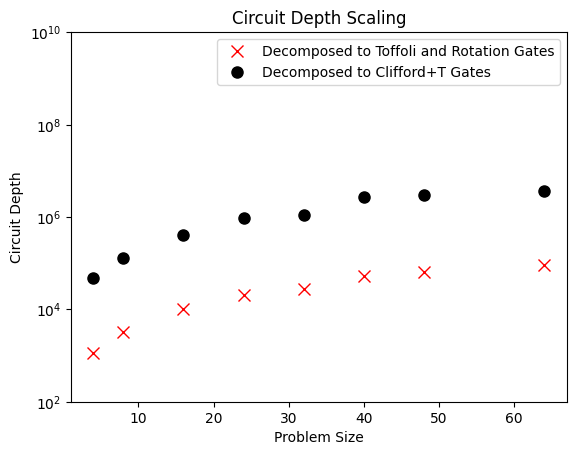

In [10]:
###
### Circuit Depth:
###

# plt.figure(figsize=(10/2,7.5/2), dpi=300)

plt.plot(data['Prob_Size'], data['Circ_Depth_Toff'], 'rx', markersize=8)
plt.plot(data['Prob_Size'], data['Circ_Depth_cliffT'], 'ko', markersize=8)
plt.yscale('log')
plt.ylim([10e1, 10e9])
plt.xlabel('Problem Size')
plt.ylabel('Circuit Depth')
plt.title('Circuit Depth Scaling')

plt.legend([
    'Decomposed to Toffoli and Rotation Gates',
    'Decomposed to Clifford+T Gates',
])